In [1]:
import logging
from datetime import datetime
import argparse
import glob
import os
from pathlib import Path

import numpy as np
import torch

import h5py

# if torch.cuda.is_available():
#     import setGPU  # noqa: F401

import tqdm
import yaml
from scipy.special import softmax
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve

from src.data.h5data import H5Data
from src.models.gnn import GraphNet

In [2]:
import matplotlib.pyplot as plt

In [3]:
project_dir = "/home/ziz078/teams/group-2/Reproduction_of_IN"
definitions = f"{project_dir}/src/data/definitions.yml"
with open(definitions) as yaml_file:
    defn = yaml.load(yaml_file, Loader=yaml.FullLoader)

N = defn["nobj_2"]  # number of charged particles
N_sv = defn["nobj_3"]  # number of SVs
n_targets = len(defn["reduced_labels"])  # number of classes
spectators = defn["spectators"]
params = defn["features_2"]
params_sv = defn["features_3"]
spectators = defn["spectators"]
labels = defn["labels"]
n_feature_sets = defn["n_feature_sets"]

In [4]:
evaluating_test = True

device = "cuda"
batch_size = 512

files_test = glob.glob(os.path.join(f"{project_dir}/data/processed/test", "newdata_*.h5"))

if evaluating_test:
    dataset = "test"
else:
    dataset = "train"

data_test = H5Data(
    batch_size=batch_size,
    cache=None,
    preloading=0,
    features_name=f"{dataset}ing_subgroup",
    labels_name="target_subgroup",
    spectators_name="spectator_subgroup",
)
data_test.set_file_names(files_test)
n_test = data_test.count_data()
print(f"test data: {n_test}")

test data: 200000


In [5]:
min_pt = -999 #300
max_pt = 99999 #2000
min_eta = -999 # no cut
max_eta = 999 # no cut
min_msd = -999 #40
max_msd = 9999 #200
vv_branch = 0
sv_branch = 1
label = 'new'
model = GraphNet(
        n_constituents=N, # (30) added this to make out_test work, but it should be set to N
        n_targets=n_targets,
        params=len(params),
        hidden=60,
        n_vertices=N_sv,
        params_v=len(params_sv),
        vv_branch=int(vv_branch),
        De=20,
        Do=24,
    ).to(device)

model.load_state_dict(torch.load(f"{project_dir}/models/trained_models/small_IN_best.pth"))
model.eval()
print(f"Parameters = {sum(p.numel() for p in model.parameters() if p.requires_grad)}")

Parameters = 25554


In [6]:
# test process
eval_path = "small_IN"
iterator = data_test.generate_data()
total_ = int(n_test / batch_size)
pbar = tqdm.tqdm(iterator, total=total_)
for j, element in enumerate(pbar):
    (sub_X, sub_Y, sub_Z) = element
    training = sub_X[2]
    training_sv = sub_X[3]
    target = sub_Y[0]
    spectator = sub_Z[0]

    # mask away selection
    fj_pt = spectator[:, 0, 0]
    fj_eta = spectator[:, 0, 1]
    fj_sdmass = spectator[:, 0, 2]
    no_undef = fj_pt > -999  # no cut
    mask = (
        (fj_sdmass > min_msd)
        & (fj_sdmass < max_msd)
        & (fj_eta > min_eta)
        & (fj_eta < max_eta)
        & (fj_pt > min_pt)
        & (fj_pt < max_pt)
        & no_undef
    )
    training = training[mask]
    training_sv = training_sv[mask]
    target = target[mask]
    spectator = spectator[mask]

    trainingv = torch.tensor(training, dtype=torch.float, device=device)
    trainingv_sv = torch.tensor(training_sv, dtype=torch.float, device=device)


    out_test = model(trainingv, trainingv_sv)
    out_test = out_test.cpu().data.numpy()
    out_test = softmax(out_test, axis=1)


#     print(f"j: {j}")
    if j == 0:
        prediction = out_test
        target_test = target
    else:
        prediction = np.concatenate((prediction, out_test), axis=0)
        target_test = np.concatenate((target_test, target))

auc = roc_auc_score(target_test[:, 1], prediction[:, 1])
print("AUC: ", auc)
acc = accuracy_score(target_test[:, 0], prediction[:, 0] >= 0.5)
print("Accuray: ", acc)
# checking the sums
target_sums = np.sum(target_test, 1)
prediction_sums = np.sum(prediction, 1)
idx = target_sums == 1
print("Total: {}, Target: {}, Pred: {}".format(np.sum(idx), np.sum(target_sums[idx]), np.sum(prediction_sums[idx])))
auc = roc_auc_score(target_test[idx][:, 1], prediction[idx][:, 1])
print("AUC: ", auc)
acc = accuracy_score(target_test[idx][:, 0], prediction[idx][:, 0] >= 0.5)
print("Accuray 0: ", acc)
acc = accuracy_score(target_test[idx][:, 1], prediction[idx][:, 1] >= 0.5)
print("Accuray 1: ", acc)




pu_label = eval_path

fpr, tpr, _ = roc_curve(target_test[:, 1], prediction[:, 1])


# save the predicted and true labels
model_pred_loc = f"{project_dir}/model_predictions/" + eval_path
os.makedirs(model_pred_loc, exist_ok=True)
model_name = "gnn"
np.save(
    f"{model_pred_loc}/{model_name}_pred_{pu_label}.npy",
    prediction,
)
np.save(
    f"{model_pred_loc}/{model_name}_true_labels_{pu_label}.npy",
    target_test,
)

# save fpr and tpr for roc curve
model_perf_loc = f"{project_dir}/model_performances/" + eval_path  
os.makedirs(model_perf_loc, exist_ok=True)


np.save(
    f"{model_perf_loc}/{model_name}_test_fpr_{pu_label}.npy",
    fpr,
)
np.save(
    f"{model_perf_loc}/{model_name}_test_tpr_{pu_label}.npy",
    tpr,
)

100%|██████████| 390/390 [00:13<00:00, 29.60it/s]


AUC:  0.98160392045641
Accuray:  0.904286858974359
Total: 187706, Target: 187706.0, Pred: 187706.0
AUC:  0.9829993554341869
Accuray 0:  0.9591755191629463
Accuray 1:  0.9591755191629463


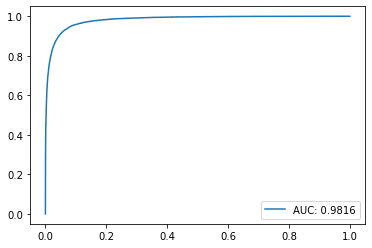

In [15]:
auc_IN = 0.98160392045641
plt.plot(fpr, tpr)
plt.legend(["AUC: {:.4f}".format(auc_IN)])

In [8]:
pred_DNN = np.load(f"{project_dir}/notebooks/pred_baseline.npy")
truth_DNN = np.load(f"{project_dir}/notebooks/truth_baseline.npy")

In [12]:
auc_DNN = roc_auc_score(truth_DNN[:, 1], pred_DNN[:, 1])

In [10]:
fpr_DNN, tpr_DNN, _ = roc_curve(truth_DNN[:, 1], pred_DNN[:, 1])

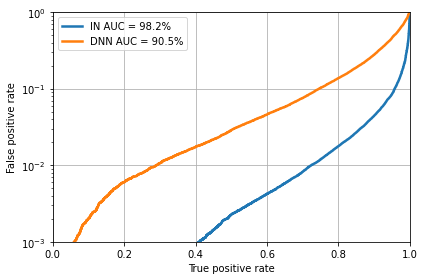

In [18]:
plt.plot(tpr, fpr, lw=2.5, label="IN AUC = {:.1f}%".format(auc_IN*100))
plt.plot(tpr_DNN, fpr_DNN, lw=2.5, label="DNN AUC = {:.1f}%".format(auc_DNN*100))
plt.xlabel(r'True positive rate')
plt.ylabel(r'False positive rate')
plt.semilogy()
plt.ylim(0.001,1)
plt.xlim(0,1)
plt.grid(True)
plt.legend(loc='upper left')
plt.tight_layout()
plt.savefig('log_ROC.png')
plt.savefig('log_ROC.pdf')

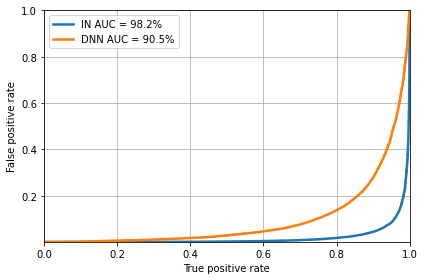

In [19]:
plt.plot(tpr, fpr, lw=2.5, label="IN AUC = {:.1f}%".format(auc_IN*100))
plt.plot(tpr_DNN, fpr_DNN, lw=2.5, label="DNN AUC = {:.1f}%".format(auc_DNN*100))
plt.xlabel(r'True positive rate')
plt.ylabel(r'False positive rate')
plt.ylim(0.001,1)
plt.xlim(0,1)
plt.grid(True)
plt.legend(loc='upper left')
plt.tight_layout()
plt.savefig('ROC_compare.png')
plt.savefig('ROC_compare.pdf')

In [20]:
acc_DNN = accuracy_score(truth_DNN[:, 0], pred_DNN[:, 0] >= 0.5)
print("DNN Accuray: ", acc_DNN)

DNN Accuray:  0.8208156720801384
